# Classification & Clustering on Articles Dataset 
## <div> Vassilis Panagakis </div>

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import csv
import warnings
import heapq
import random

pd.options.mode.chained_assignment = None  
warnings.filterwarnings('ignore')  

## Load Data

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Split Data

#### Create a dataframe from articles.tsv file data

In [4]:
articles = pd.read_csv("gdrive/My Drive/Colab Notebooks/articles.tsv", delimiter="\t", names=['Id','Title','Content','Category'], header=None, encoding='latin1')

In [5]:
#split 'Category' column from the rest of the data
X = articles
y = articles['Category']

In [7]:
from sklearn.model_selection import train_test_split

#get train and test dataframes 
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, stratify=articles['Category'], random_state = 42)

#### Create tab-seperated train_set.tsv file 

In [9]:
train_X.to_csv("gdrive/My Drive/Colab Notebooks/train_set.tsv", header=False, sep='\t', index = False)

In [10]:
#totally remove 'Category' column from test set
test_X.drop(['Category'], 1, inplace=True)

#### Create tab-seperated test_set.tsv file 

In [11]:
test_X.to_csv("gdrive/My Drive/Colab Notebooks/test_set.tsv", header=False, sep='\t', index = False)

### Load Data

#### Display some samples of our initial data

In [12]:
train = pd.read_csv("gdrive/My Drive/Colab Notebooks/train_set.tsv", delimiter="\t", names=['Id','Title','Content','Category'], header=None)

train.head()

Id  ...       Category
0  1628  ...          sport
1    40  ...       business
2   850  ...  entertainment
3  1939  ...           tech
4   515  ...  entertainment

[5 rows x 4 columns]

In [13]:
test = pd.read_csv("gdrive/My Drive/Colab Notebooks/test_set.tsv", delimiter="\t", names=['Id','Title','Content'], header=None)

test.head()

Id  ...                                            Content
0  1222  ...  So who, if anyone, is playing politics with th...
1   562  ...  Film-maker Spike Lee says black representation...
2   696  ...  Johnny Vaughan and Denise Van Outen's Saturday...
3   824  ...  The 77th annual Academy Awards are taking plac...
4   271  ...  Arsenal vice-chairman David Dein has said the ...

[5 rows x 3 columns]

### Data Preprocessing

In [14]:
#function that removes all non alphabetic strings 
def clean_content(text):
    
    text =  ''.join(ch for ch in text if ch.isalpha() or ch == ' ')
    
    text = text.lower() #convert text into lowercase
    
    return text

#### Create a column for each set with cleaned 'Content' data

In [15]:
for index, row in train.iterrows():
    train.loc[index,'CleanContent'] = clean_content(train.loc[index,'Content'])

In [16]:
for index, row in test.iterrows():
    test.loc[index,'CleanContent'] = clean_content(test.loc[index,'Content'])

### Tokenization

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()

tokens = []
for index, row in train.iterrows(): #add each article's token in a list
    toks = tknzr.tokenize(train.loc[index,'CleanContent'])
    
    toks = [w for w in toks if not w in stopwords.words('english')] 
    
    tokens.append(toks)

#create a column in train set with articles' tokens 
train['Tokens'] = pd.Series(tokens,index=train.index)

In [22]:
tokens = []
for index, row in test.iterrows(): #add each article's token in a list
    toks = tknzr.tokenize(test.loc[index,'CleanContent'])
    
    toks = [w for w in toks if not w in stopwords.words('english')] 
    
    tokens.append(toks)
    
#create a column in test set with articles' tokens   
test['Tokens'] = pd.Series(tokens,index=test.index)

### Stemming - Lemmatization

In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [25]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemContent = []
for index, row in train.iterrows(): #add each token's lemma in a list
    lemmas = []
    for token in train.loc[index,'Tokens']:
        lemmas.append(lemmatizer.lemmatize(token))
    lemContent.append(lemmas)

#replace train set's tokens with their lemmas
train.drop(['Tokens'],1,inplace=True)
train['Tokens'] = pd.Series(lemContent,index=train.index)

In [26]:
lemmatizer = WordNetLemmatizer()

lemContent = []
for index, row in test.iterrows(): #add each token's lemma in a list
    lemmas = []
    for token in test.loc[index,'Tokens']:
        lemmas.append(lemmatizer.lemmatize(token))
    lemContent.append(lemmas)

#replace test set's tokens with their lemmas    
test.drop(['Tokens'],1,inplace=True)
test['Tokens'] = pd.Series(lemContent,index=test.index)

#### Display some samples of our updated data

In [27]:
train.head()

Id  ...                                             Tokens
0  1628  ...  [england, centre, olly, barkley, passed, fit, ...
1    40  ...  [uk, sportswear, firm, umbro, posted, rise, an...
2   850  ...  [robert, de, niro, completed, transatlantic, b...
3  1939  ...  [oldfashioned, audio, tour, historical, place,...
4   515  ...  [stage, adaptation, childrens, film, mary, pop...

[5 rows x 6 columns]

In [28]:
test.head()

Id  ...                                             Tokens
0  1222  ...  [anyone, playing, politics, security, nationmi...
1   562  ...  [filmmaker, spike, lee, say, black, representa...
2   696  ...  [johnny, vaughan, denise, van, outens, saturda...
3   824  ...  [th, annual, academy, award, taking, place, fe...
4   271  ...  [arsenal, vicechairman, david, dein, said, clu...

[5 rows x 5 columns]

## Data Analysis

In [29]:
allToks = []
busToks = []
enterToks = []
politToks = []
sportToks = []
techToks = []
busCount, enterCount, politCount, sportCount, techCount = (0,0,0,0,0)

for index, row in train.iterrows():
    if train.loc[index,'Category'] == 'business':
        busCount+=1
        for token in train.loc[index,'Tokens']:
            busToks.append(token)
    elif train.loc[index,'Category'] == 'entertainment':
        enterCount+=1
        for token in train.loc[index,'Tokens']:
            enterToks.append(token)
    elif train.loc[index,'Category'] == 'politics':
        politCount+=1
        for token in train.loc[index,'Tokens']:
            politToks.append(token)
    elif train.loc[index,'Category'] == 'sport':
        sportCount+=1
        for token in train.loc[index,'Tokens']:
            sportToks.append(token)
    else:
        techCount+=1
        for token in train.loc[index,'Tokens']:
            techToks.append(token)
    for token in train.loc[index,'Tokens']:
        allToks.append(token)

#### Illustrate the volume of each article's Category in the train set

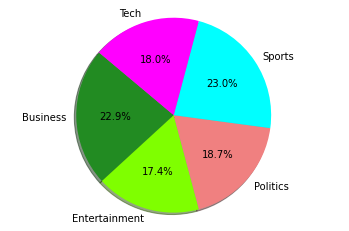

In [30]:
labels = 'Business', 'Entertainment', 'Politics', 'Sports', 'Tech'
sizes = [busCount, enterCount, politCount, sportCount, techCount]
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#  <h1><center>WORDCLOUDS</center></h1> 

In [34]:
from wordcloud import WordCloud, STOPWORDS 
from collections import Counter

#define the STOPWORDS set and update it with some user defined stopwords
stopwords = set(STOPWORDS)
stopwords.update(["said", "say", "told", "people", "bn", "year", "one", "last", "time", "new", "mr", "best", "party"])

#### On business articles

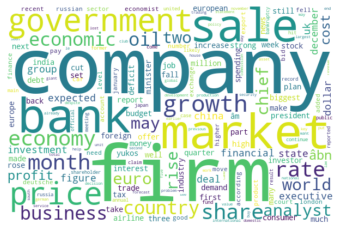

In [35]:
count = Counter(busToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud 
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### On entertainment articles

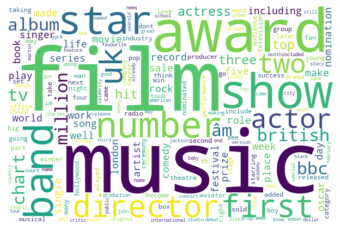

In [36]:
count = Counter(enterToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### On politics articles

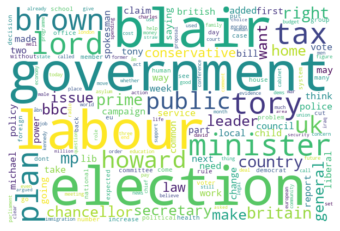

In [37]:
count = Counter(politToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### On sports articles

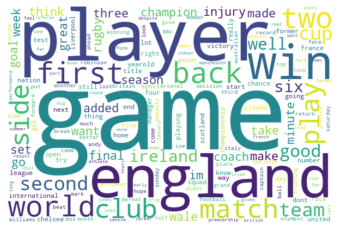

In [38]:
count = Counter(sportToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### On tech articles

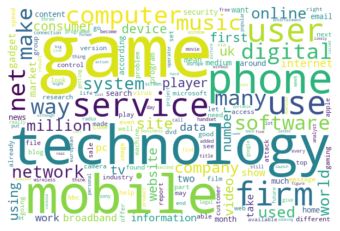

In [39]:
count = Counter(techToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### On all articles

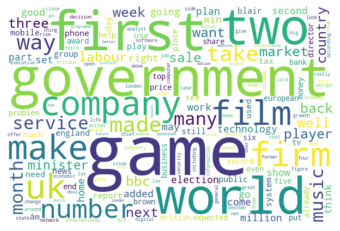

In [40]:
count = Counter(allToks)
common = ""
for word, times in count.most_common(200): #include just the 200 most common words to create the wordcloud
    common = common + " " + word

wc = WordCloud(stopwords=stopwords, background_color="white", width=600, height=400,).generate(common)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# <h1><center>CLASSIFICATION</center></h1>

### Label Preprocessing

In [42]:
from sklearn import preprocessing

#transform string labels to numerical labels
encoder = preprocessing.LabelEncoder() 

# encode train and test labels 
encoder.fit(train_Y)
train_y = encoder.transform(train_Y)

encoder.fit(test_Y)
test_y = encoder.transform(test_Y)

### Vectorization

### Word Counts 

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

countVectorizer = CountVectorizer(max_df=0.99, min_df=1, max_features=350, stop_words='english',
                                     strip_accents='unicode', analyzer='word')

In [44]:
bow = countVectorizer.fit_transform(train['CleanContent'])

vectors = []
for v in bow.toarray():
    vectors.append(v)

#create a column in train set with articles' words counts   
train['document-words'] = pd.Series(vectors,index=train.index)

In [45]:
bow = countVectorizer.fit_transform(test['CleanContent'])

vectors = []
for v in bow.toarray():
    vectors.append(v)

#create a column in test set with articles' words counts   
test['document-words'] = pd.Series(vectors,index=test.index)

### Tf-Idf

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(max_df=0.99, min_df=1, max_features=350, stop_words='english',
                                     strip_accents='unicode', analyzer='word')

In [47]:
tfidf = tfidfVectorizer.fit_transform(train['CleanContent'])

vectors = []
for v in tfidf.toarray():
    vectors.append(v)

#create a column in train set with articles' words tf-idf counts transformation
train['tf-idf'] = pd.Series(vectors,index=train.index)

In [48]:
tfidf = tfidfVectorizer.fit_transform(test['CleanContent'])

vectors = []
for v in tfidf.toarray():
    vectors.append(v)

#create a column in test set with articles' words tf-idf counts transformation    
test['tf-idf'] = pd.Series(vectors,index=test.index)

#### Display some samples of our updated data after vectorization

In [49]:
train.head()

Id  ...                                             tf-idf
0  1628  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0634941629609...
1    40  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.113...
2   850  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.16922580523651679,...
3  1939  ...  [0.08790247156173632, 0.0, 0.0, 0.0, 0.0, 0.0,...
4   515  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[5 rows x 8 columns]

In [50]:
test.head()

Id  ...                                             tf-idf
0  1222  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1   562  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.17810371705944092,...
2   696  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1538183424875...
3   824  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.1170964737219121, ...
4   271  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[5 rows x 7 columns]

#### Insert 'document-words' and 'tf-idf' columns to arrays

In [51]:
train_bow = np.asarray(train['document-words'].tolist())
train_tfidf = np.asarray(train['tf-idf'].tolist())

In [52]:
test_bow = np.asarray(test['document-words'].tolist())
test_tfidf = np.asarray(test['tf-idf'].tolist())

### Evaluation Functions

In [53]:
md={}

#function that uses values from a dictionary to create a dataframe to store model evaluation values
def model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std):

    md['classifier'] = classifier
    md['avg-precision'] = avg_prec
    md['precision-std'] = prec_std
    md['avg-recall'] = avg_rec
    md['recall-std'] = rec_std
    md['avg-f1-score'] = avg_f1
    md['f1-score-std'] = f1_std
    md['avg-accuracy'] = avg_acc
    md['accuracy-std'] = acc_std
    
    df = pd.DataFrame(data=md) #create dataframe from dictionary data
    
    return df 

#### Create a dataframe to store the prediction-accuracy values of the classifiers

In [54]:
cl_dic = {'SVM':['-','-'], 'RF':['-','-'], 'NB':['-','-'], 'KNN':['-','-']}

cl_df = pd.DataFrame.from_dict(cl_dic, orient='index', columns=['BOW','TF-IDF'])

In [56]:
from sklearn.model_selection import KFold, StratifiedKFold

#define k-fold evaluation methods
numOfFolds = 10
cv1 = KFold(n_splits=numOfFolds, shuffle=True)
cv2 = StratifiedKFold(n_splits=numOfFolds, shuffle=True)

In [67]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

#scoring methods that calculate the precision, recall and f-mesure values for every fold of k-fold cross validation 

def precEval(y_true, y_pred):
    fold_report = classification_report(y_true, y_pred, output_dict=True)
    prec = fold_report['macro avg']['precision']
    return prec

def recEval(y_true, y_pred):
    fold_report = classification_report(y_true, y_pred, output_dict=True)
    rec = fold_report['macro avg']['recall']
    return rec

def f1Eval(y_true, y_pred):
    fold_report = classification_report(y_true, y_pred, output_dict=True)
    f1 = fold_report['macro avg']['f1-score']
    return f1

In [87]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#function that creates ROC plots for multiclass classifiers 
#based on 10-fold Cross Validation on train set and predictions on test set
def multiclass_roc_plot(clf, train_X, train_y, test_X, test_y, title1, title2):
    classes=['Business', 'Entertainment', 'Politics', 'Sports', 'Tech']
    colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']
    clen = len(classes)    
    clf_name = type(clf).__name__
    
    #predict probability with different function for every classifier
    if clf_name == 'SVC':
        score_y = clf.decision_function(test_X)
        method='decision_function'
    elif clf_name == 'ComplementNB' or clf_name == 'BernoulliNB':
        score_y = clf.predict_log_proba(test_X)
        method='predict_log_proba'
    elif clf_name == 'RandomForestClassifier' or clf_name == 'MyKnnClassifier':
        score_y = clf.predict_proba(test_X)
        method='predict_proba'    
     
    plt.figure(figsize=(7,4), dpi=120) 

    plt.subplot(1,2,1)
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    y_bin = label_binarize(train_y, classes=[0, 1, 2, 3, 4]) #binarize class labels
    y_score = cross_val_predict(clf, train_X, train_y, cv=10, method=method) #cross validation prediction
 
    for i in range(clen):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # roc for each class
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title(title1, fontsize=10)
    
    for i, color in zip(range(clen),colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], classes[i]))
    
    plt.legend(loc='lower right', prop={'size': 5})
    plt.grid(alpha=.4)
    sns.despine()
    
    plt.subplot(1,2,2)
    fpr = {}
    tpr = {}
    roc_auc = {}
     
    test_y_dummies = pd.get_dummies(test_y, drop_first=False).values #get dummies
    for i in range(clen):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], score_y[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # roc for each class
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title(title2, fontsize=11)
        
    for i, color in zip(range(clen),colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], classes[i]))
    
    plt.legend(loc='lower right', prop={'size': 5})
    plt.grid(alpha=.4)
    sns.despine()

## SVM

In [78]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

### Word Counts - rbf kernel  

In [79]:
from sklearn.svm import SVC

classifier.append('SVM(bow-rbf_kernel)')

svc_bow_rbf = SVC(C=1000, kernel='rbf', gamma=0.001)
svc_bow_rbf.fit(train_bow, train_y)

y_pred_bow_rbf = svc_bow_rbf.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_bow_rbf, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_bow_rbf, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_bow_rbf, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_bow_rbf, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

bow_rbf_svc = "%.3f%%" % (accuracy_score(test_y, y_pred_bow_rbf) * 100)

### Word Counts - linear kernel  

In [80]:
classifier.append('SVM(bow-linear_kernel)')

svc_bow_lin = SVC(C=1, kernel='linear')
svc_bow_lin.fit(train_bow, train_y)

y_pred_bow_lin = svc_bow_lin.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_bow_lin, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_bow_lin, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_bow_lin, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_bow_lin, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

bow_lin_svc = "%.3f%%" % (accuracy_score(test_y, y_pred_bow_lin) * 100)

In [81]:
if bow_rbf_svc >= bow_lin_svc:
    cl_df.loc['SVM','BOW'] = bow_rbf_svc
else:
    cl_df.loc['SVM','BOW'] = bow_lin_svc

### Tf-Idf - rbf kernel  

In [82]:
classifier.append('SVM(tfidf-rbf_kernel)')

svc_tfidf_rbf = SVC(C=100, kernel='rbf', gamma=0.001)
svc_tfidf_rbf.fit(train_tfidf, train_y)

y_pred_tfidf_rbf = svc_tfidf_rbf.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_tfidf_rbf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_tfidf_rbf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_tfidf_rbf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_tfidf_rbf, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

tfidf_rbf_svc = "%.3f%%" % (accuracy_score(test_y, y_pred_tfidf_rbf) * 100)

### Tf-Idf - linear kernel  

In [83]:
classifier.append('SVM(tfidf-linear_kernel)')

svc_tfidf_lin = SVC(C=1, kernel='linear', gamma=0.001)
svc_tfidf_lin.fit(train_tfidf, train_y)

y_pred_tfidf_lin = svc_tfidf_lin.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_tfidf_lin, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_tfidf_lin, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_tfidf_lin, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_tfidf_lin, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

tfidf_lin_svc = "%.3f%%" % (accuracy_score(test_y, y_pred_tfidf_lin) * 100)

In [84]:
if tfidf_rbf_svc >= tfidf_lin_svc:
    cl_df.loc['SVM','TF-IDF'] = tfidf_rbf_svc
else:
    cl_df.loc['SVM','TF-IDF'] = tfidf_lin_svc

### Model Evaluation

In [85]:
svm_mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
svm_mdf

classifier avg-precision  ...  avg-accuracy accuracy-std
0       SVM(bow-rbf_kernel)       93.276%  ...       93.371%     0.021140
1    SVM(bow-linear_kernel)       93.531%  ...       93.596%     0.009468
2     SVM(tfidf-rbf_kernel)       94.376%  ...       94.719%     0.020749
3  SVM(tfidf-linear_kernel)       95.000%  ...       95.281%     0.013103

[4 rows x 9 columns]

### ROC Plots

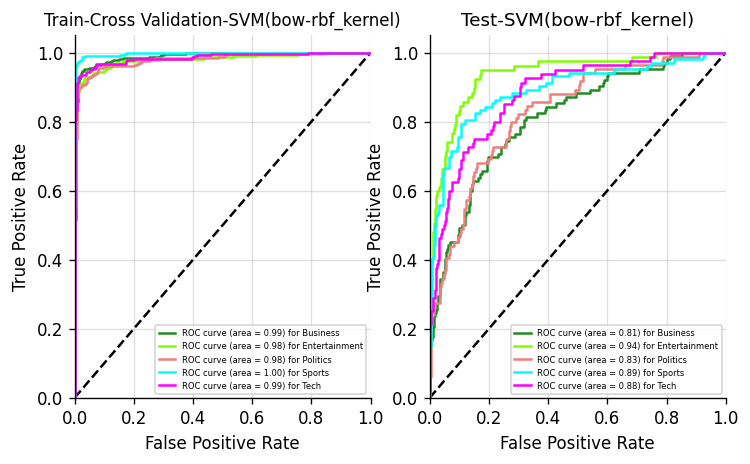

In [88]:
multiclass_roc_plot(svc_bow_rbf, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-SVM(bow-rbf_kernel)', title2='Test-SVM(bow-rbf_kernel)')

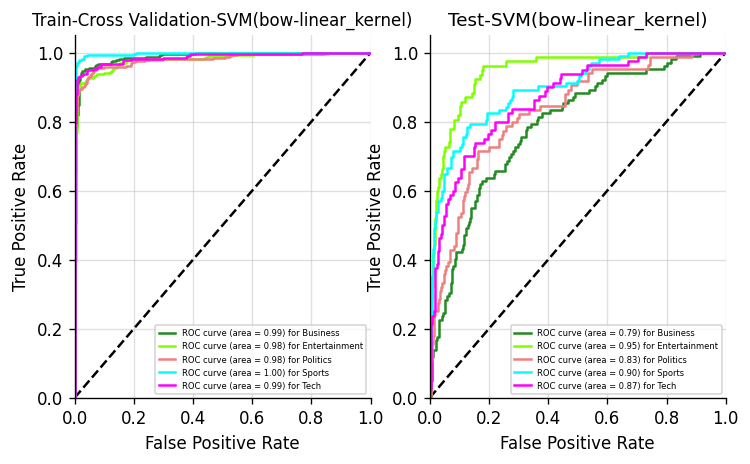

In [89]:
multiclass_roc_plot(svc_bow_lin, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-SVM(bow-linear_kernel)', title2='Test-SVM(bow-linear_kernel)')

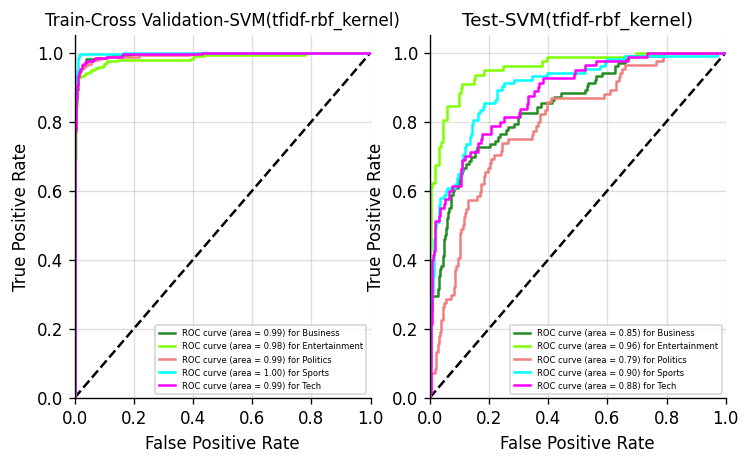

In [90]:
multiclass_roc_plot(svc_tfidf_rbf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-SVM(tfidf-rbf_kernel)', title2='Test-SVM(tfidf-rbf_kernel)')

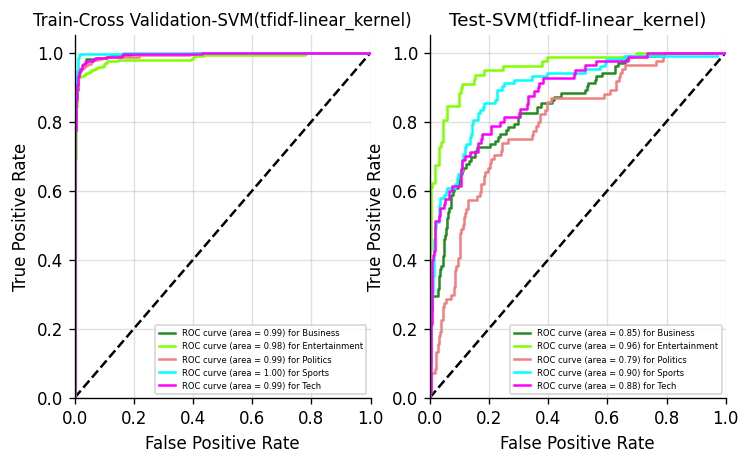

In [91]:
multiclass_roc_plot(svc_tfidf_rbf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-SVM(tfidf-linear_kernel)', title2='Test-SVM(tfidf-linear_kernel)')

## Random Forest

In [92]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

### Word Counts

In [93]:
from sklearn.ensemble import RandomForestClassifier

classifier.append('RF(bow)') 

rf_bow = RandomForestClassifier(n_estimators = 1000, max_depth = 90, min_samples_split = 12,  
                                 min_samples_leaf = 3, max_features = 3, max_leaf_nodes = 15)
rf_bow.fit(train_bow, train_y)

y_pred_rf_bow = rf_bow.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(rf_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(rf_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(rf_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(rf_bow, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['RF','BOW'] = "%.3f%%" % (accuracy_score(test_y, y_pred_rf_bow) * 100)

### Tf-Idf 

In [94]:
classifier.append('RF(tfidf)') 

rf_tfidf = RandomForestClassifier(n_estimators = 1000, max_depth = 30, min_samples_split = 12,  
                                 min_samples_leaf = 3, max_features = 3, max_leaf_nodes = 15)
rf_tfidf.fit(train_tfidf, train_y)

y_pred_rf_tfidf = rf_tfidf.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(rf_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(rf_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(rf_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(rf_tfidf, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['RF','TF-IDF'] = "%.3f%%" % (accuracy_score(test_y, y_pred_rf_tfidf) * 100)

### Model Evaluation

In [95]:
rf_mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
rf_mdf

classifier avg-precision  ...  avg-accuracy accuracy-std
0    RF(bow)       92.330%  ...       90.449%     0.022047
1  RF(tfidf)       92.401%  ...       90.843%     0.015498

[2 rows x 9 columns]

### ROC Plots

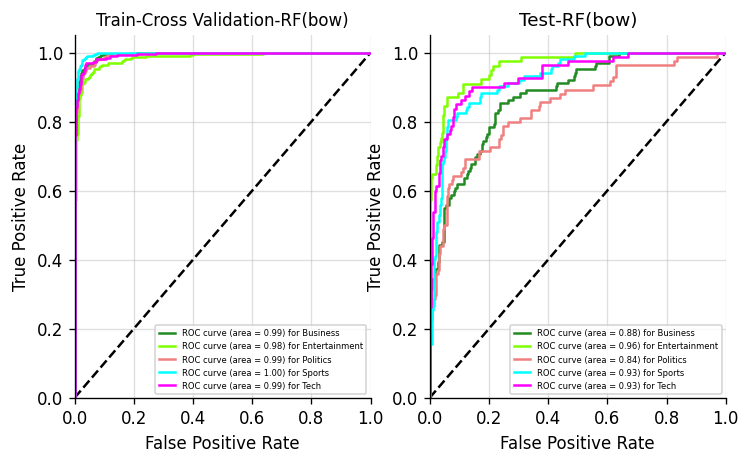

In [96]:
multiclass_roc_plot(rf_bow, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-RF(bow)', title2='Test-RF(bow)')

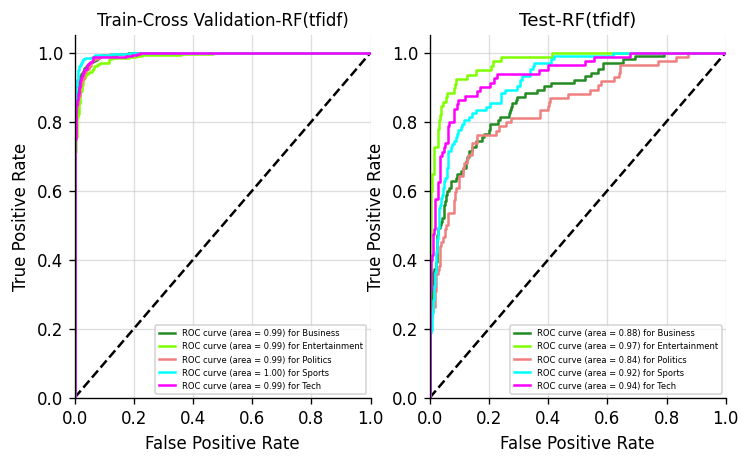

In [97]:
multiclass_roc_plot(rf_tfidf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-RF(tfidf)', title2='Test-RF(tfidf)')

## Naive Bayes

In [103]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

### Word Counts

In [106]:
from sklearn.naive_bayes import BernoulliNB, ComplementNB

classifier.append('CNB(bow)') 
# classifier.append('BNB(bow)')

nb_bow = ComplementNB() #Complement Naive Bayes (an adaptation of Multinomial Naive Bayes suited for imbalanced data sets)
# nb_bow = BernoulliNB() #Bernoulli Naive Bayes (data that is distributed according to multivariate Bernoulli distributions)

nb_bow.fit(train_bow, train_y)

y_pred_nb_bow = nb_bow.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(nb_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(nb_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(nb_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(nb_bow, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['NB','BOW'] = "%.3f%%" % (accuracy_score(test_y, y_pred_nb_bow) * 100)

### Tf-Idf 

In [107]:
classifier.append('CNB(tfidf)') 
# classifier.append('BNB(tfidf)')

nb_tfidf = ComplementNB() #Complement Naive Bayes (an adaptation of Multinomial Naive Bayes suited for imbalanced data sets)
# nb_tfidf = BernoulliNB() #Bernoulli Naive Bayes (data that is distributed according to multivariate Bernoulli distributions)

nb_tfidf.fit(train_tfidf, train_y)

y_pred_nb_tfidf = nb_bow.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(nb_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(nb_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(nb_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(nb_tfidf, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['NB','TF-IDF'] = "%.3f%%" % (accuracy_score(test_y, y_pred_nb_tfidf) * 100)

### Model Evaluation

In [108]:
nb_mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
nb_mdf

classifier avg-precision  ...  avg-accuracy accuracy-std
0    CNB(bow)       91.683%  ...       91.348%     0.016703
1  CNB(tfidf)       91.919%  ...       91.742%     0.011527
2    BNB(bow)       92.669%  ...       92.865%     0.023306
3  BNB(tfidf)       92.773%  ...       92.978%     0.021795

[4 rows x 9 columns]

### ROC Plots

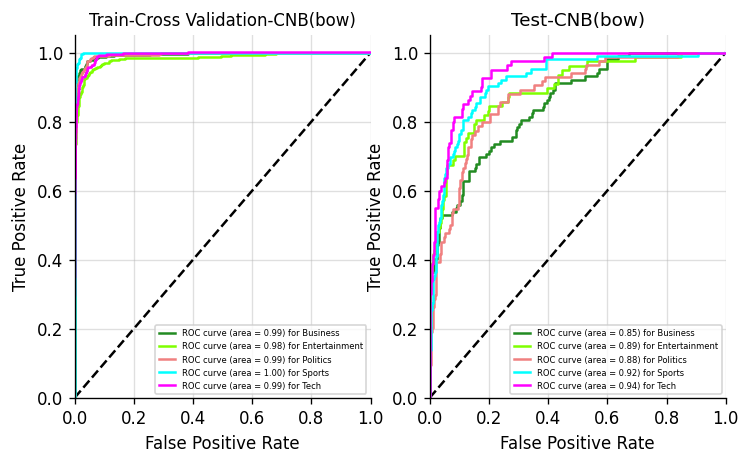

In [109]:
multiclass_roc_plot(nb_bow, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-CNB(bow)', title2='Test-CNB(bow)')

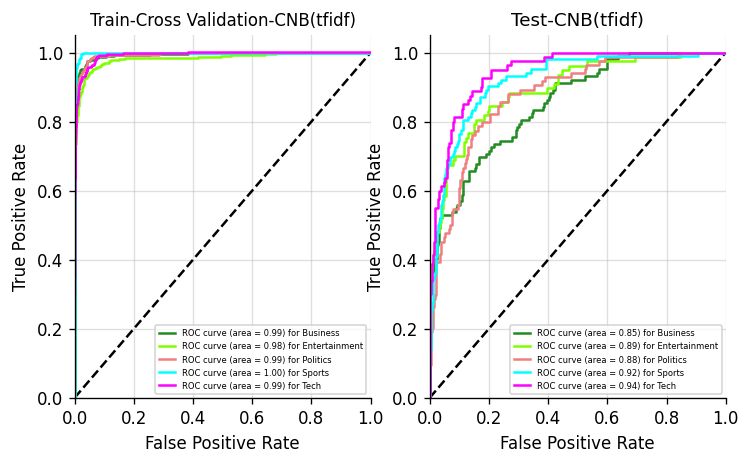

In [110]:
multiclass_roc_plot(nb_tfidf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-CNB(tfidf)', title2='Test-CNB(tfidf)')

## k-Nearest Neighbor

In [111]:
#function that implements a majority voting algorithm in a linear time - constant space way
def majority_voting(lab_list):
    cand = -1
    count = 0
    
    for l in lab_list:
        if count != 0: 
            count += 1 if cand == l else -1
        else: 
            cand = l
            count = 1

    #return majority element if it appears more than k/2 times in list of labels, else return a random label in list
    return cand if lab_list.count(cand) >= len(lab_list) // 2 else random.choice(lab_list)

In [118]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.extmath import softmax

#my own implementation of k-Nearest Neighbor Classifier
class MyKnnClassifier(BaseEstimator):  
    
    def __init__(self, k=10):
        self.k = k
        
    def fit(self, train_X, train_y):
        train_X, train_y = check_X_y(train_X, train_y) #check if train_X and train_y have correct shape
        
        self.classes_ = unique_labels(train_y) #store the fitted classes 
        self.X_ = train_X
        self.y_ = train_y
        
        return self
        
    def predict(self, test_X):
        check_is_fitted(self) #check if fit() had been executed

        cosim = cosine_similarity(test_X, self.X_) #calculate cosine similarity between train and test sets
        top_ind = [(heapq.nlargest((self.k+1), range(len(ind)), ind.take)) for ind in cosim] # get k most similar indices
        top_lab = [[self.y_[l] for l in ind[:self.k]] for ind in top_ind] # convert indices to labels
        
        #get prediction using a majority voting algorithm
        pred = [majority_voting(ind) for ind in top_lab]
        pred = np.array(pred)

        return pred
    
    def predict_proba(self, test_X):
        cosim = cosine_similarity(test_X, self.X_) #calculate cosine similarity between train and test sets
        neg_cosim = np.negative(cosim) #get negative distance so that the probability is inversely proportional to distance
        
        #use a "soft" nearest neighbour classification (softmax(x) = np.exp(x)/sum(np.exp(x)))
        prob = softmax(neg_cosim)
        
        return prob 

In [119]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

### Word Counts

In [120]:
classifier.append('KNN(bow)') 

knn_bow = MyKnnClassifier(k=51)
knn_bow.fit(train_bow, train_y)

y_pred_knn_bow = knn_bow.predict(test_bow) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(knn_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(knn_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(knn_bow, train_bow, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(knn_bow, train_bow, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['KNN','BOW']  = "%.3f%%" % (accuracy_score(test_y, y_pred_knn_bow) * 100)

### Tf-Idf 

In [121]:
classifier.append('KNN(tfidf)') 

knn_tfidf = MyKnnClassifier(k=44)
knn_tfidf.fit(train_tfidf, train_y)

y_pred_knn_tfidf = knn_tfidf.predict(test_tfidf) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(knn_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(knn_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(knn_tfidf, train_tfidf, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(knn_tfidf, train_tfidf, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

cl_df.loc['KNN','TF-IDF'] = "%.3f%%" % (accuracy_score(test_y, y_pred_knn_tfidf) * 100)

### Model Evaluation

In [122]:
knn_mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
knn_mdf

classifier avg-precision  ...  avg-accuracy accuracy-std
0    KNN(bow)       84.157%  ...       83.933%     0.024514
1  KNN(tfidf)       89.138%  ...       88.820%     0.017488

[2 rows x 9 columns]

### ROC Plots

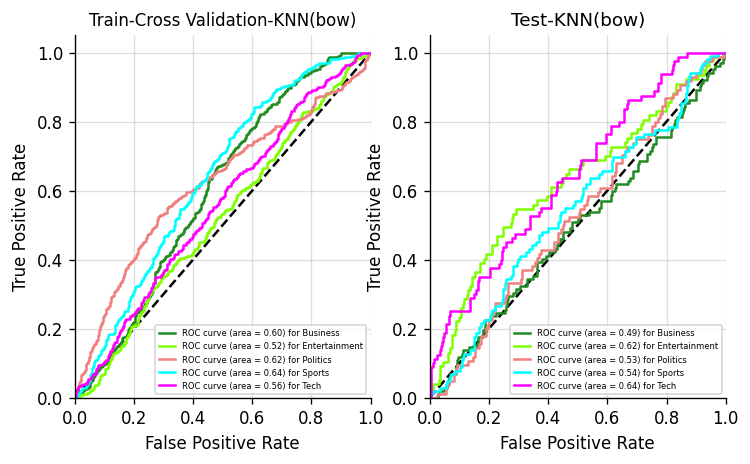

In [123]:
multiclass_roc_plot(knn_bow, train_bow, train_y, test_bow, test_y, 
                    title1='Train-Cross Validation-KNN(bow)', title2='Test-KNN(bow)')

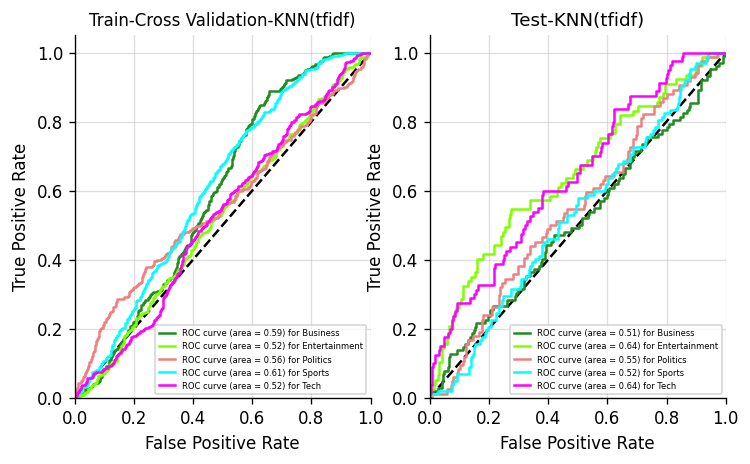

In [124]:
multiclass_roc_plot(knn_tfidf, train_tfidf, train_y, test_tfidf, test_y, 
                    title1='Train-Cross Validation-KNN(tfidf)', title2='Test-KNN(tfidf)')

### Classifiers Prediction-Accuracy Evaluation

In [125]:
cl_df

BOW   TF-IDF
SVM  60.225%  61.573%
RF   68.090%  68.539%
NB   57.753%  57.753%
KNN  43.820%  52.135%

# <h1><center>Optimize a Classifier - SVM(tfidf-rbf_kernel)</center></h1>

#### Create a dataframe to store the prediction-accuracy value of the optimized SVM classifier

In [126]:
cl_ext_dic = {'SVM':['-']}

cl_ext_df = pd.DataFrame.from_dict(cl_ext_dic, orient='index', columns=['TF-IDF'])

#### Create a column for each set with cleaned 'Title' data

In [127]:
for index, row in train.iterrows():
    train.loc[index,'CleanTitle'] = clean_content(train.loc[index,'Title'])

In [128]:
for index, row in test.iterrows():
    test.loc[index,'CleanTitle'] = clean_content(test.loc[index,'Title'])

#### Create new dataframe columns including both 'CleanTitle' and 'CleanContent' data

In [129]:
train['CleanText'] = train[['CleanTitle', 'CleanContent']].agg(' '.join, axis=1)
test['CleanText'] = test[['CleanTitle', 'CleanContent']].agg(' '.join, axis=1)

In [130]:
tfidfVectorizer = TfidfVectorizer(max_df=0.99, min_df=1, max_features=350, stop_words='english',
                                    strip_accents='unicode', analyzer='word', token_pattern=r'\w+', 
                                    use_idf=True, smooth_idf=True, sublinear_tf=True)

tfidf = tfidfVectorizer.fit_transform(train['CleanText'])

vectors = []
for v in tfidf.toarray():
    vectors.append(v)

#create a column in train set with articles' title and content words tf-idf counts transformation
train['tf-idf-extended'] = pd.Series(vectors,index=train.index)

In [131]:
tfidf = tfidfVectorizer.fit_transform(test['CleanText'])

vectors = []
for v in tfidf.toarray():
    vectors.append(v)

#create a column in test set with articles' title and content words tf-idf counts transformation
test['tf-idf-extended'] = pd.Series(vectors,index=test.index)

#### Insert 'tf-idf-extended' columns to arrays 

In [132]:
train_tfidf_ext = np.asarray(train['tf-idf-extended'].tolist())
test_tfidf_ext = np.asarray(test['tf-idf-extended'].tolist())

In [135]:
#initialize empty lists to store column values of the dataframe
classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std = ([] for i in range(9))

In [136]:
classifier.append('SVM(tfidf-rbf_kernel)')

svc_tfidf_ext_rbf = SVC(C=100, kernel='rbf', gamma=0.001)
svc_tfidf_ext_rbf.fit(train_tfidf_ext, train_y)

y_pred_tfidf_ext_rbf = svc_tfidf_ext_rbf.predict(test_tfidf_ext) #prediction on test set

#stratified 10-fold Cross Validation on train set
prec = cross_val_score(svc_tfidf_ext_rbf, train_tfidf_ext, train_y, cv=cv2, scoring=make_scorer(precEval))
rec = cross_val_score(svc_tfidf_ext_rbf, train_tfidf_ext, train_y, cv=cv2, scoring=make_scorer(recEval))
f1 = cross_val_score(svc_tfidf_ext_rbf, train_tfidf_ext, train_y, cv=cv2, scoring=make_scorer(f1Eval))
acc = cross_val_score(svc_tfidf_ext_rbf, train_tfidf_ext, train_y, cv=cv2, scoring='accuracy')

av_prec = "%.3f%%" % (prec.mean() * 100)
av_rec = "%.3f%%" % (rec.mean() * 100)
av_f1 = "%.3f%%" % (f1.mean() * 100)
av_acc = "%.3f%%" % (acc.mean() * 100)

avg_prec.append(av_prec), prec_std.append(prec.std())
avg_rec.append(av_rec), rec_std.append(rec.std())
avg_f1.append(av_f1), f1_std.append(f1.std())
avg_acc.append(av_acc), acc_std.append(acc.std())

tfidf_ext_rbf_svc = "%.3f%%" % (accuracy_score(test_y, y_pred_tfidf_ext_rbf) * 100)

### Model Evaluation

#### All SVM Classifiers (Before Optimization) 

In [140]:
svm_mdf

classifier avg-precision  ...  avg-accuracy accuracy-std
0       SVM(bow-rbf_kernel)       93.276%  ...       93.371%     0.021140
1    SVM(bow-linear_kernel)       93.531%  ...       93.596%     0.009468
2     SVM(tfidf-rbf_kernel)       94.376%  ...       94.719%     0.020749
3  SVM(tfidf-linear_kernel)       95.000%  ...       95.281%     0.013103

[4 rows x 9 columns]

#### SVM(tfidf - rbf_kernel) (Before Optimization) 

In [141]:
svm_mdf.loc[svm_mdf['classifier'] == 'SVM(tfidf-rbf_kernel)']

classifier avg-precision  ...  avg-accuracy accuracy-std
2  SVM(tfidf-rbf_kernel)       94.376%  ...       94.719%     0.020749

[1 rows x 9 columns]

#### SVM(tfidf - rbf_kernel) (After Optimization) 

In [142]:
mdf = model_dataframe(classifier, avg_prec, prec_std, avg_rec, rec_std, avg_f1, f1_std, avg_acc, acc_std)
mdf

classifier avg-precision  ...  avg-accuracy accuracy-std
0  SVM(tfidf-rbf_kernel)       95.738%  ...       95.562%     0.019855

[1 rows x 9 columns]

### ROC Plots

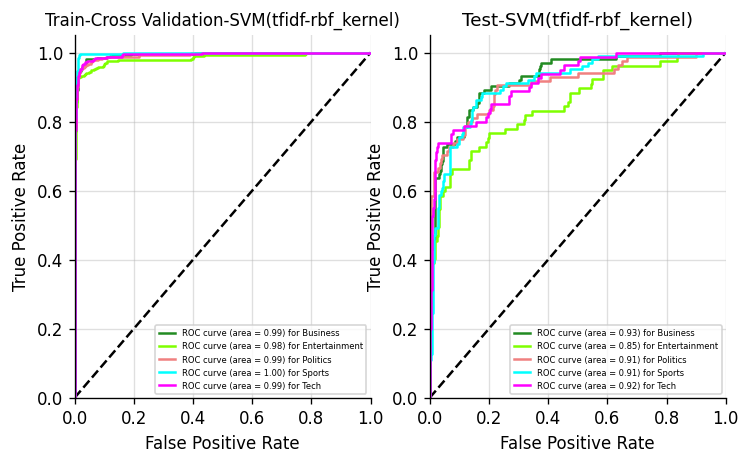

In [143]:
multiclass_roc_plot(svc_tfidf_ext_rbf, train_tfidf, train_y, test_tfidf_ext, test_y, 
                    title1='Train-Cross Validation-SVM(tfidf-rbf_kernel)', title2='Test-SVM(tfidf-rbf_kernel)')

### (Updated) Classifiers Prediction-Accuracy Evaluation

#### SVM(tfidf - rbf_kernel) (Before Optimization)

In [144]:
cl_df.head(1)

BOW   TF-IDF
SVM  60.225%  61.573%

#### Best-Prediction Classifier (Before Optimization)

In [145]:
cl_df[cl_df['TF-IDF'] == cl_df['TF-IDF'].max()]

BOW   TF-IDF
RF  68.090%  68.539%

####  SVM(tfidf - rbf_kernel) (After Optimization)

In [146]:
cl_ext_df.loc['SVM','TF-IDF'] = tfidf_ext_rbf_svc
cl_ext_df

TF-IDF
SVM  71.461%

**Before the SVM (tfidf - linear_kernel) optimization, the Random Forest classifier had the best results among all the classifiers concerning the prediction accuracy on the test set.<br>Yet, after the optimization SVM classifier's prediction accuracy rose by 115% (~71%) and became the most accurate among all the classifiers.**

# <h1><center>CLUSTERING</center></h1>

## Bag of Words - Word Counts

### K-Means

In [147]:
#if we normalise the train set data and run k-means with Euclidean distance metric,
#we get the same result, as if we had immediately run k-means with Cosine Similarity metric
train_bow_norm = preprocessing.normalize(train_bow)

In [150]:
from sklearn.cluster import KMeans

km_bow = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0).fit(train_bow_norm)

In [151]:
#create a dataframe that contains k-means' predicted labels
km_bow_df = pd.DataFrame(data=km_bow.labels_, columns=["Category"])

### PCA

In [152]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_bow = pca.fit_transform(train_bow_norm)

#### Create a dataframe that contains the two principal components

In [153]:
pca_bow_df = pd.DataFrame(data=pca_bow, columns=['principal component 1', 'principal component 2'])

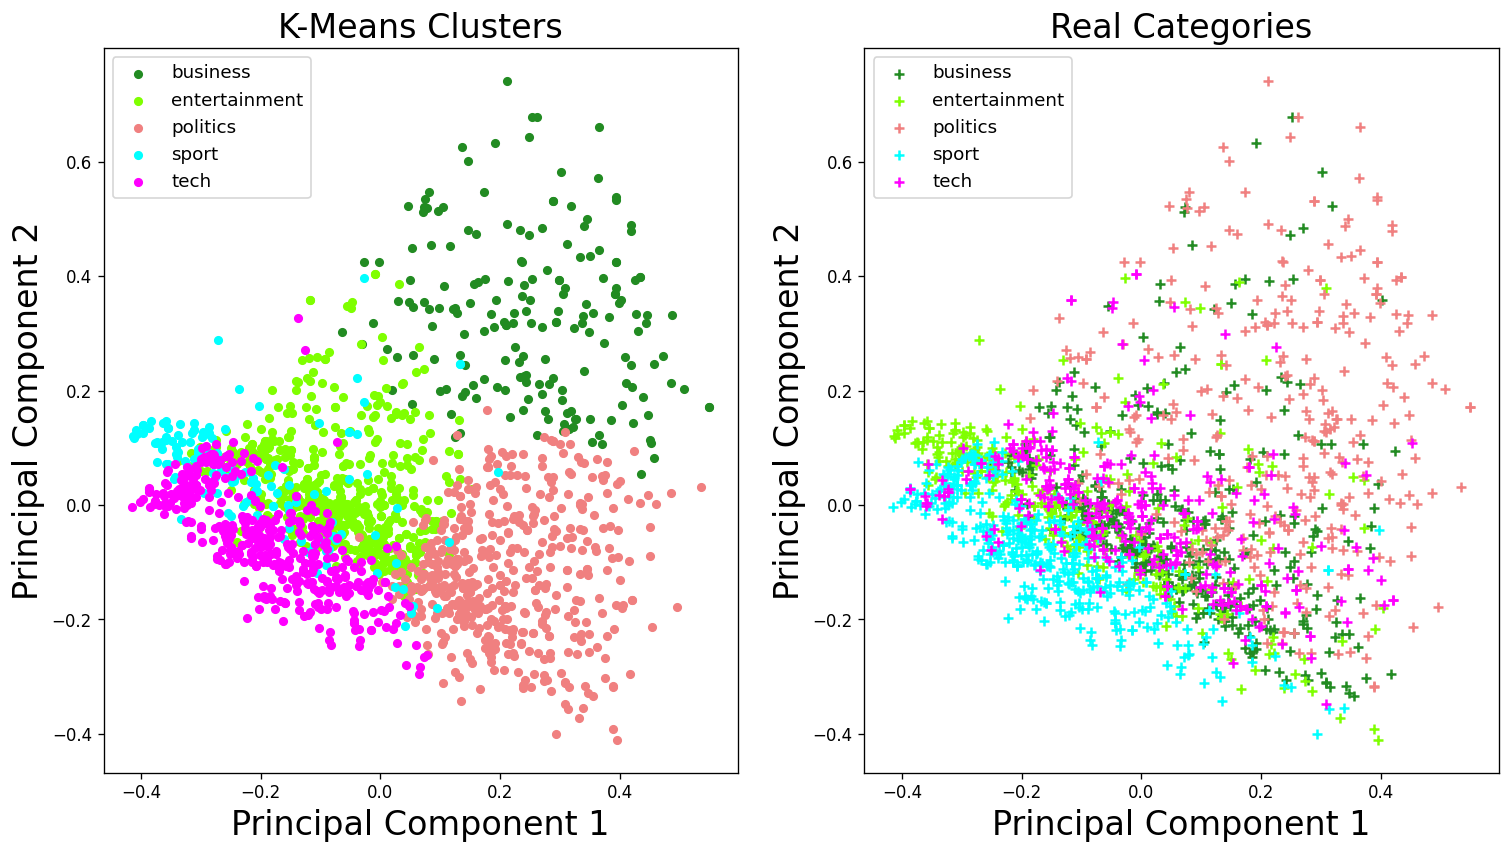

In [154]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_bow_df['Category'] == ncl
    plt.scatter(pca_bow_df.loc[index, 'principal component 1'], 
                pca_bow_df.loc[index, 'principal component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(pca_bow_df.loc[index, 'principal component 1'], 
                pca_bow_df.loc[index, 'principal component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### SVD

In [155]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd_bow = svd.fit_transform(train_bow_norm)

#### Create a dataframe that contains the two components

In [156]:
svd_bow_df = pd.DataFrame(data=svd_bow, columns=['component 1', 'component 2'])

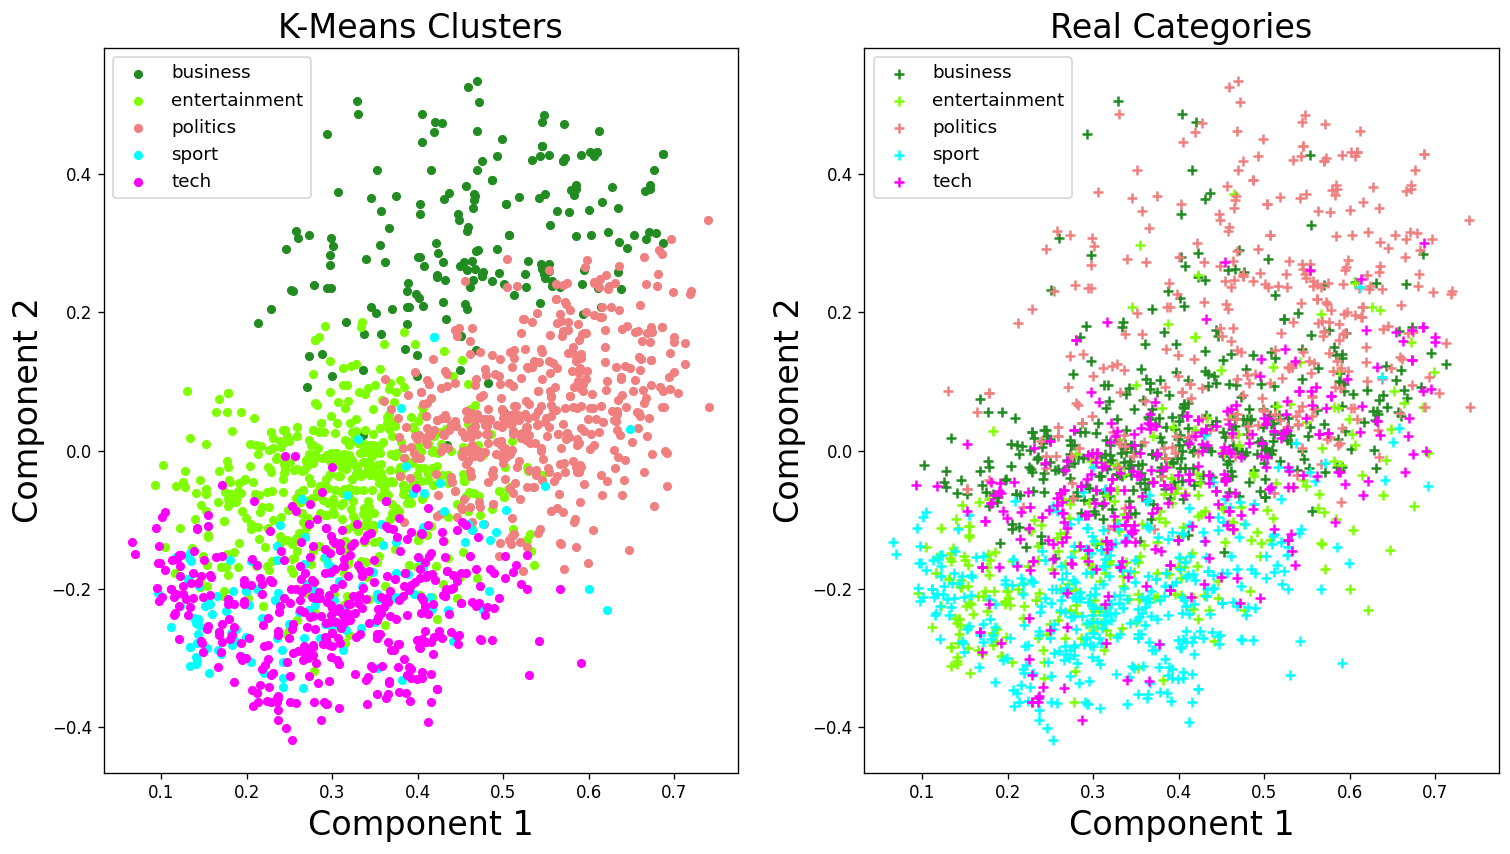

In [157]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_bow_df['Category'] == ncl
    plt.scatter(svd_bow_df.loc[index, 'component 1'], 
                svd_bow_df.loc[index, 'component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(svd_bow_df.loc[index, 'component 1'], 
                svd_bow_df.loc[index, 'component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### ICA

In [158]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2, algorithm = 'deflation')
ica_bow = ica.fit_transform(train_bow_norm)

#### Create a dataframe that contains the two independent components

In [159]:
ica_bow_df = pd.DataFrame(data=ica_bow, columns=['independent component 1', 'independent component 2'])

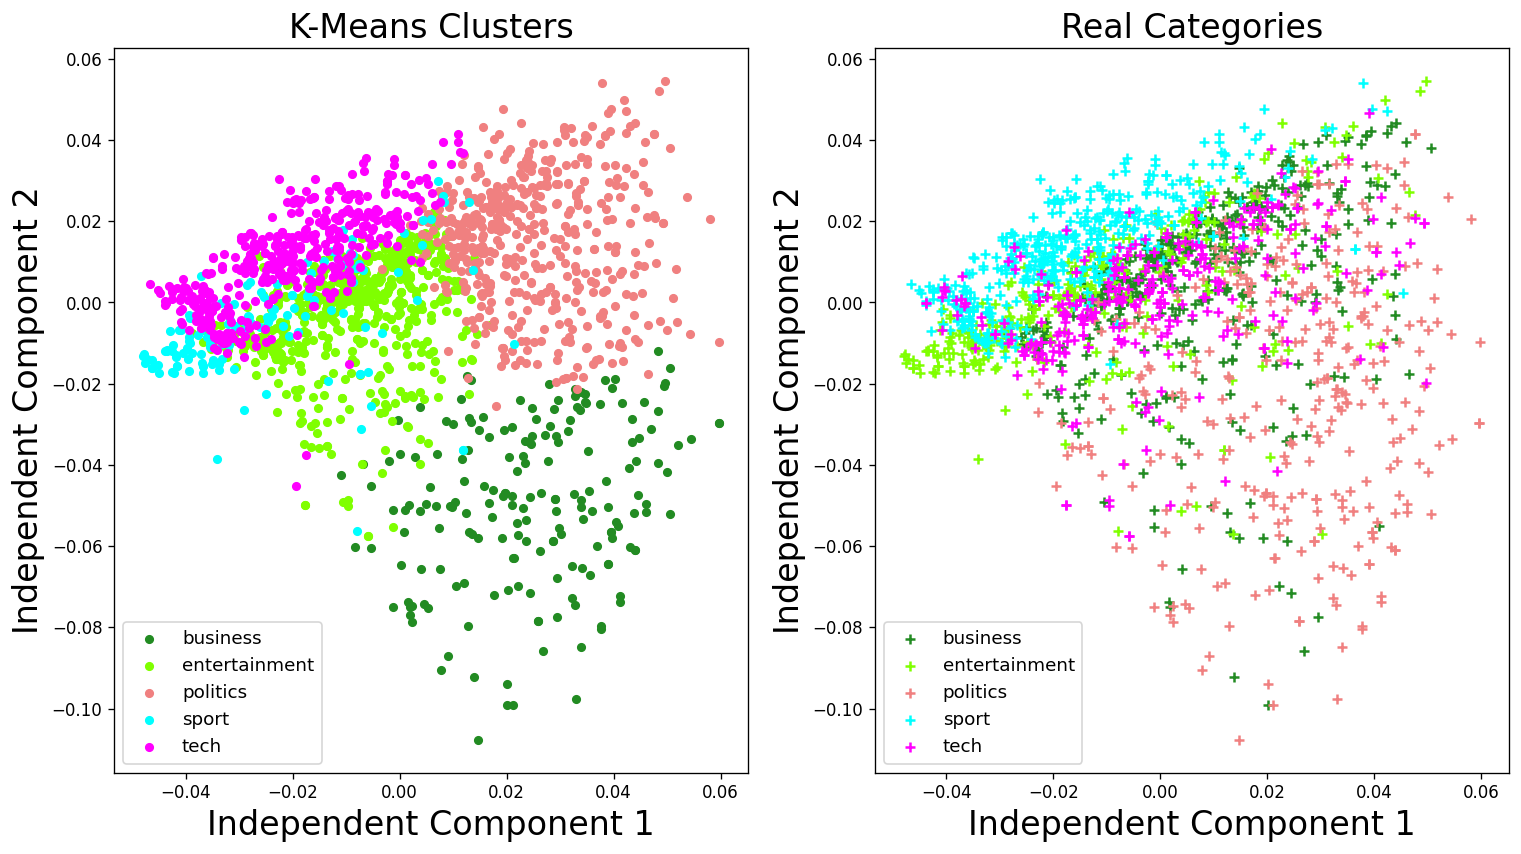

In [160]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_bow_df['Category'] == ncl
    plt.scatter(ica_bow_df.loc[index, 'independent component 1'], 
                ica_bow_df.loc[index, 'independent component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(ica_bow_df.loc[index, 'independent component 1'], 
                ica_bow_df.loc[index, 'independent component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

## Bag of Words - Tf-Idf

### K-Means

In [161]:
#if we normalise the train set data and run k-means with Euclidean distance metric,
#we get the same result, as if we had immediately run k-means with Cosine Similarity metric
train_tfidf_norm = preprocessing.normalize(train_tfidf)

In [162]:
km_tfidf = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0).fit(train_tfidf_norm)

In [163]:
#create a dataframe that contains k-means' predicted labels
km_tfidf_df = pd.DataFrame(data=km_tfidf.labels_, columns=["Category"])

### PCA

In [164]:
pca = PCA(n_components=2)
pca_tfidf = pca.fit_transform(train_tfidf_norm)

#### Create a dataframe that contains the two principal components

In [165]:
pca_tfidf_df = pd.DataFrame(data=pca_tfidf, columns=['principal component 1', 'principal component 2'])

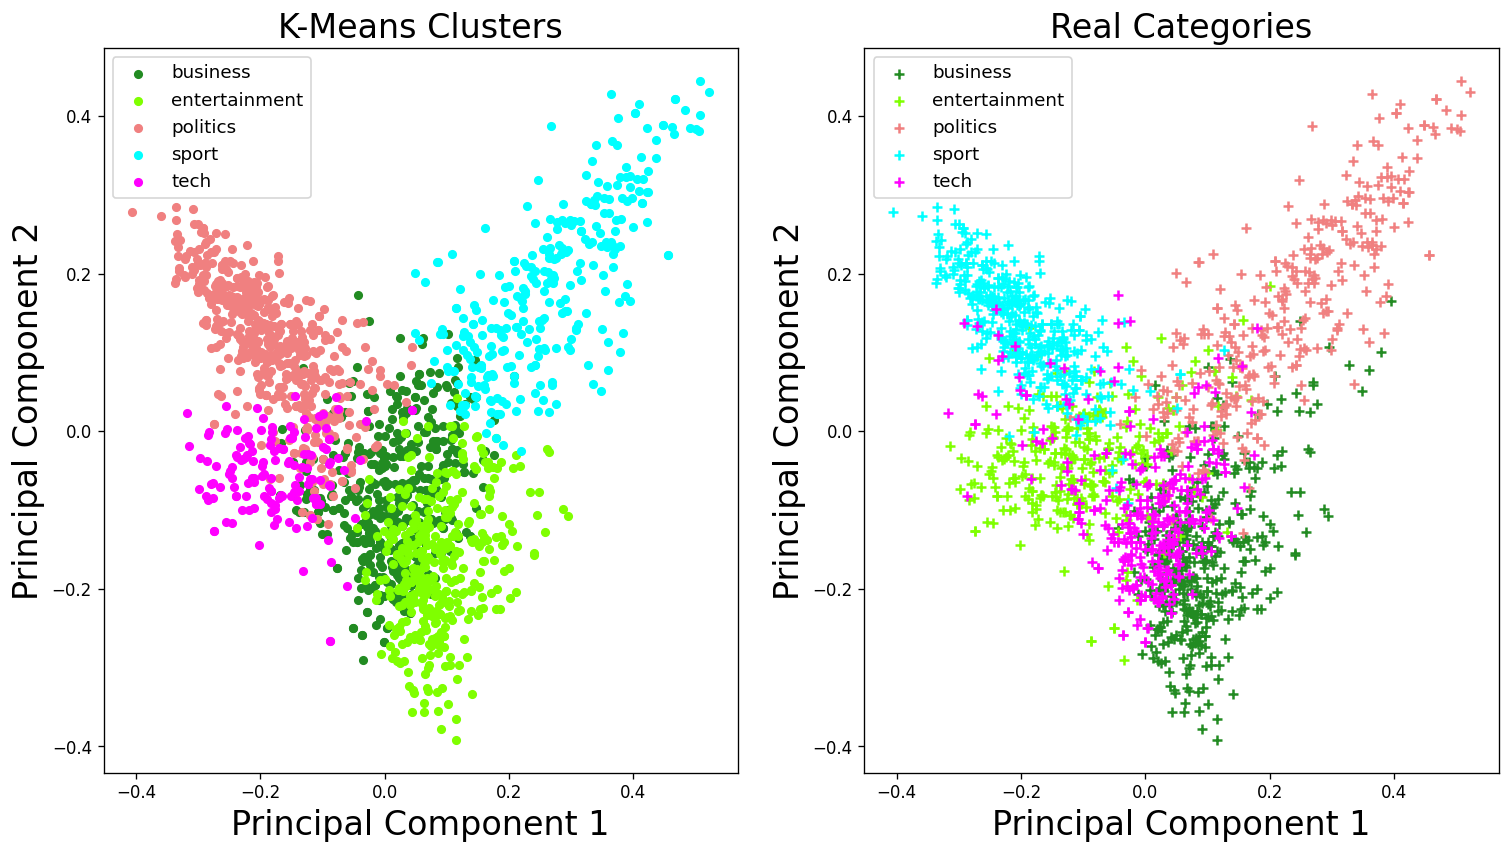

In [166]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_tfidf_df['Category'] == ncl
    plt.scatter(pca_tfidf_df.loc[index, 'principal component 1'], 
                pca_tfidf_df.loc[index, 'principal component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(pca_tfidf_df.loc[index, 'principal component 1'], 
                pca_tfidf_df.loc[index, 'principal component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### SVD

In [167]:
svd = TruncatedSVD(n_components=2)
svd_tfidf = svd.fit_transform(train_tfidf_norm)

#### Create a dataframe that contains the two independent components

In [168]:
svd_tfidf_df = pd.DataFrame(data=svd_tfidf, columns=['component 1', 'component 2'])

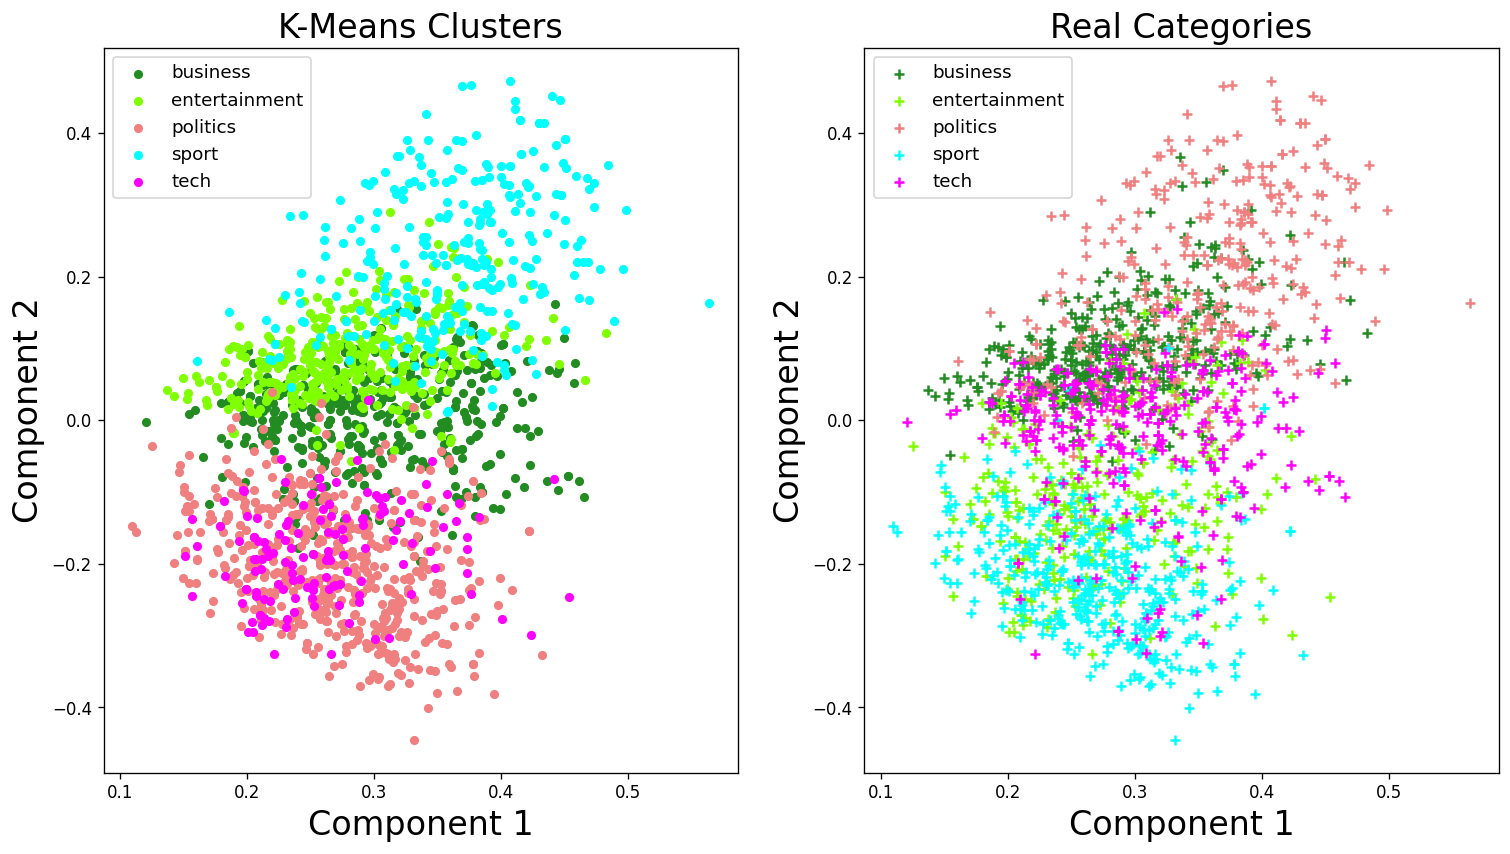

In [169]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_tfidf_df['Category'] == ncl
    plt.scatter(svd_tfidf_df.loc[index, 'component 1'], 
                svd_tfidf_df.loc[index, 'component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(svd_tfidf_df.loc[index, 'component 1'], 
                svd_tfidf_df.loc[index, 'component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### ICA

In [170]:
ica = FastICA(n_components=2, algorithm='deflation')
ica_tfidf = ica.fit_transform(train_tfidf_norm)

#### Create a dataframe that contains the two independent components

In [171]:
ica_tfidf_df = pd.DataFrame(data=ica_tfidf, columns=['independent component 1', 'independent component 2'])

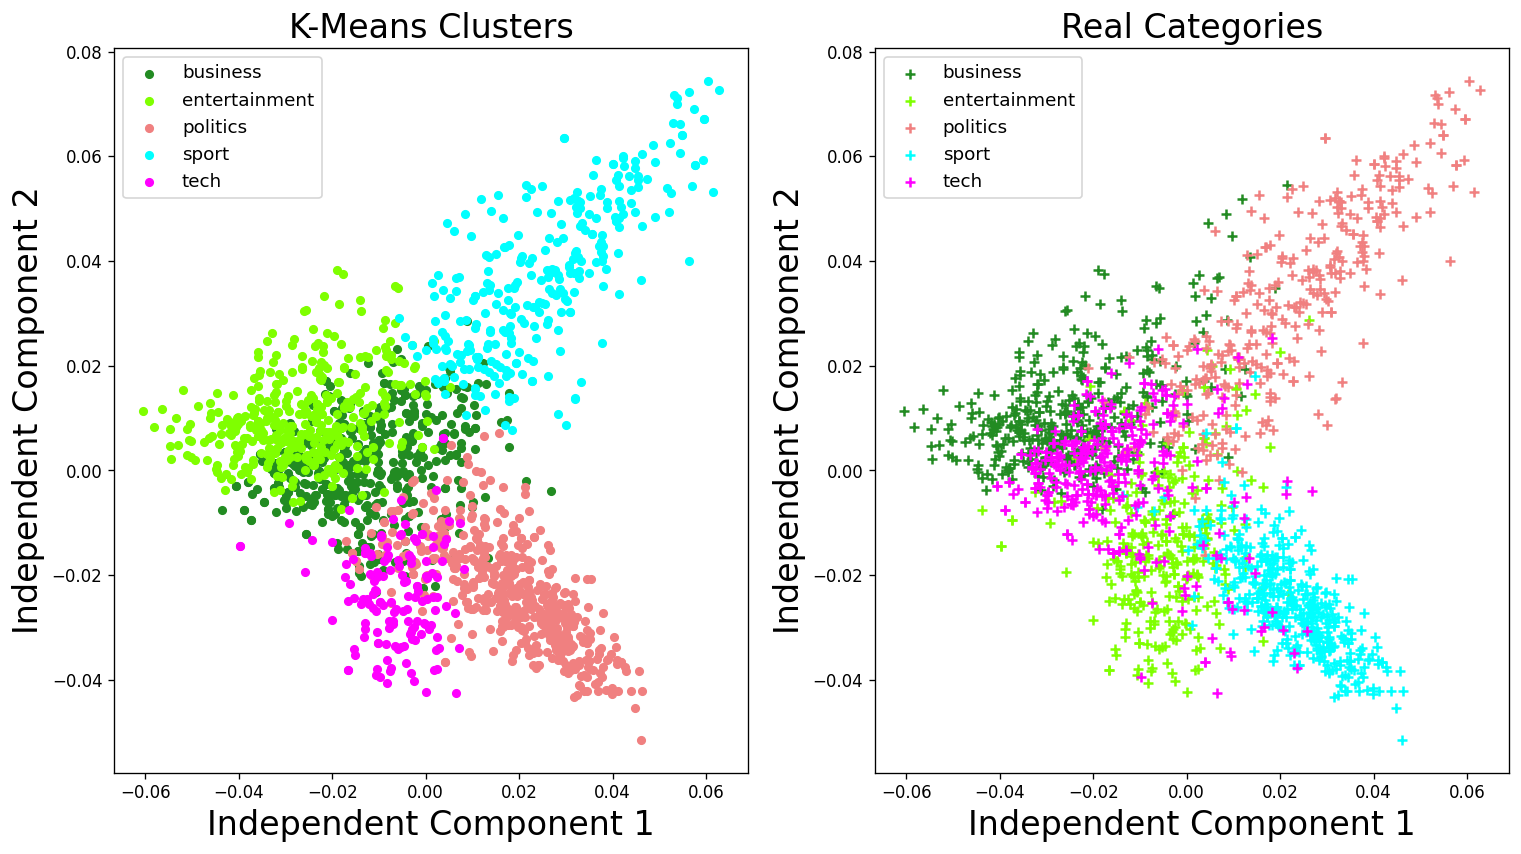

In [172]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_tfidf_df['Category'] == ncl
    plt.scatter(ica_tfidf_df.loc[index, 'independent component 1'], 
                ica_tfidf_df.loc[index, 'independent component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(ica_tfidf_df.loc[index, 'independent component 1'], 
                ica_tfidf_df.loc[index, 'independent component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

## Pre-trained Embeddings - Word2Vec

In [174]:
from gensim.models import Word2Vec

w2v = Word2Vec(train['Tokens'], size=300, window=5, min_count=100, negative=10)
w2v_model = w2v.train(train['Tokens'], total_examples=len(train['Tokens']), epochs=20)

In [175]:
def tokens_to_vector(tokens, w2v):
    vectors = []
    
    for token in tokens:
        if token in w2v: #if word is part of the Word2Vec dictionary, add it to the list
            vectors.append(w2v[token]) 
        else:
            vectors.append((np.random.rand(300)*2 - 1)) # else, add a random word to the list
            
    total = np.zeros(300) 
    
    for v in vectors: #compute the mean vector
        total += v
        
    return total / len(vectors)   

In [176]:
vectors = []

for index, row in train.iterrows():
    vectors.append(tokens_to_vector(train.loc[index,'Tokens'], w2v)) 

#create a column in train set with articles' Word2Vec pre-trained embeddings
train['document-embeddings'] = pd.Series(vectors,index=train.index)

#### Insert 'document-embeddings' column to array 

In [177]:
train_w2v = np.asarray(train['document-embeddings'].tolist())

### K-Means

In [178]:
#if we normalise the train set data and run k-means with Euclidean distance metric,
#we get the same result, as if we had immediately run k-means with Cosine Similarity metric
train_w2v_norm = preprocessing.normalize(train_w2v)

In [179]:
km_w2v = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0).fit(train_w2v_norm)

In [180]:
#create a dataframe that contains k-means' predicted labels
km_w2v_df = pd.DataFrame(data=km_w2v.labels_, columns=["Category"])

### PCA

In [181]:
pca = PCA(n_components=2)
pca_w2v = pca.fit_transform(train_w2v_norm)

#### Create a dataframe that contains the two principal components

In [182]:
pca_w2v_df = pd.DataFrame(data=pca_w2v, columns=['principal component 1', 'principal component 2'])

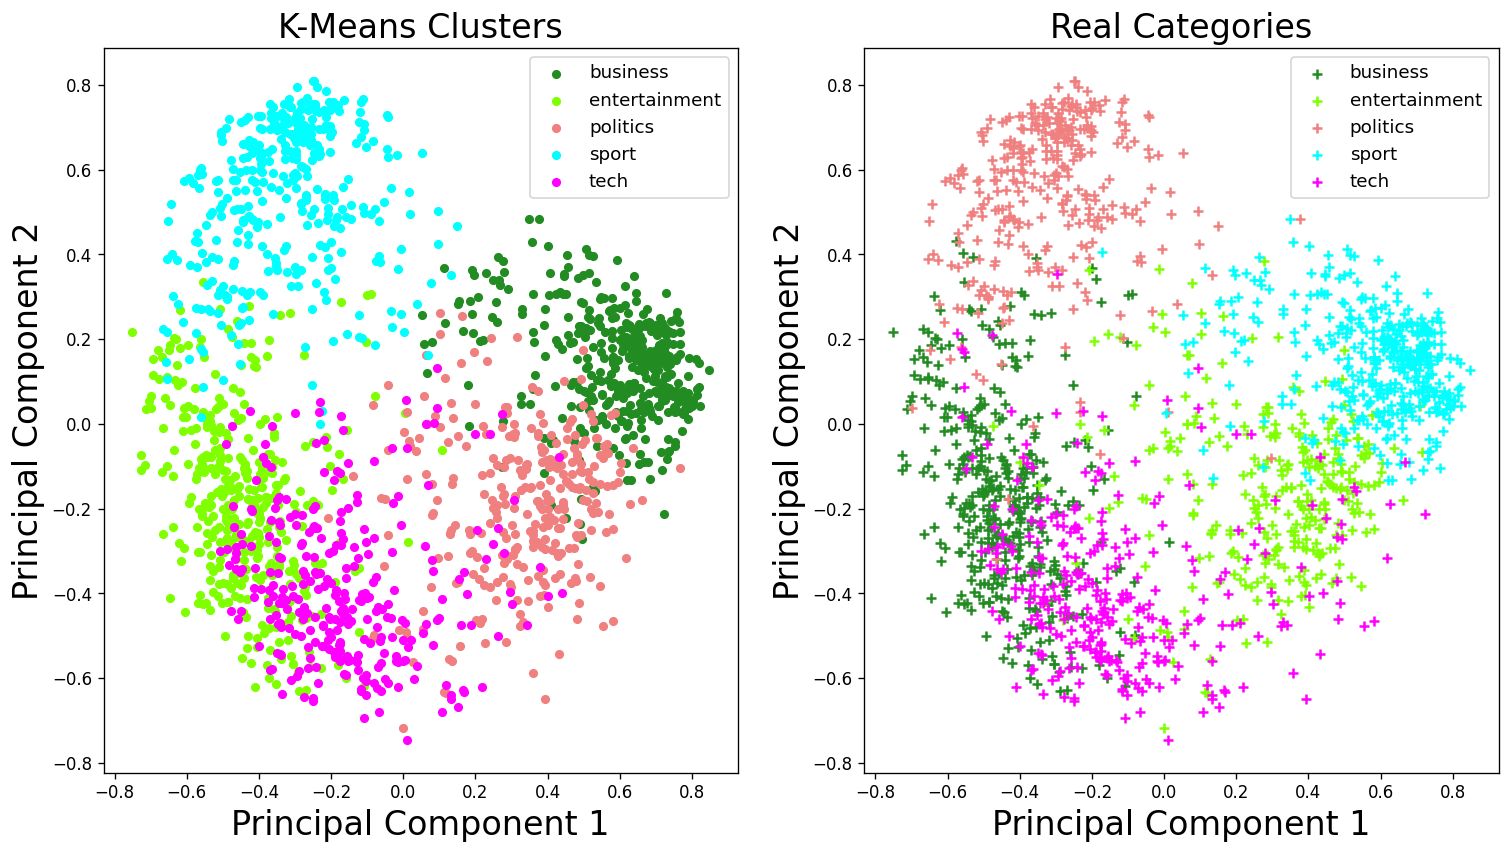

In [183]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_w2v_df['Category'] == ncl
    plt.scatter(pca_w2v_df.loc[index, 'principal component 1'], 
                pca_w2v_df.loc[index, 'principal component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Principal Component 1', fontsize=20)
plt.ylabel('Principal Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(pca_w2v_df.loc[index, 'principal component 1'], 
                pca_w2v_df.loc[index, 'principal component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### SVD

In [184]:
svd = TruncatedSVD(n_components=2)
svd_w2v = svd.fit_transform(train_w2v_norm)

#### Create a dataframe that contains the two components

In [185]:
svd_w2v_df = pd.DataFrame(data=svd_w2v, columns=['component 1', 'component 2'])

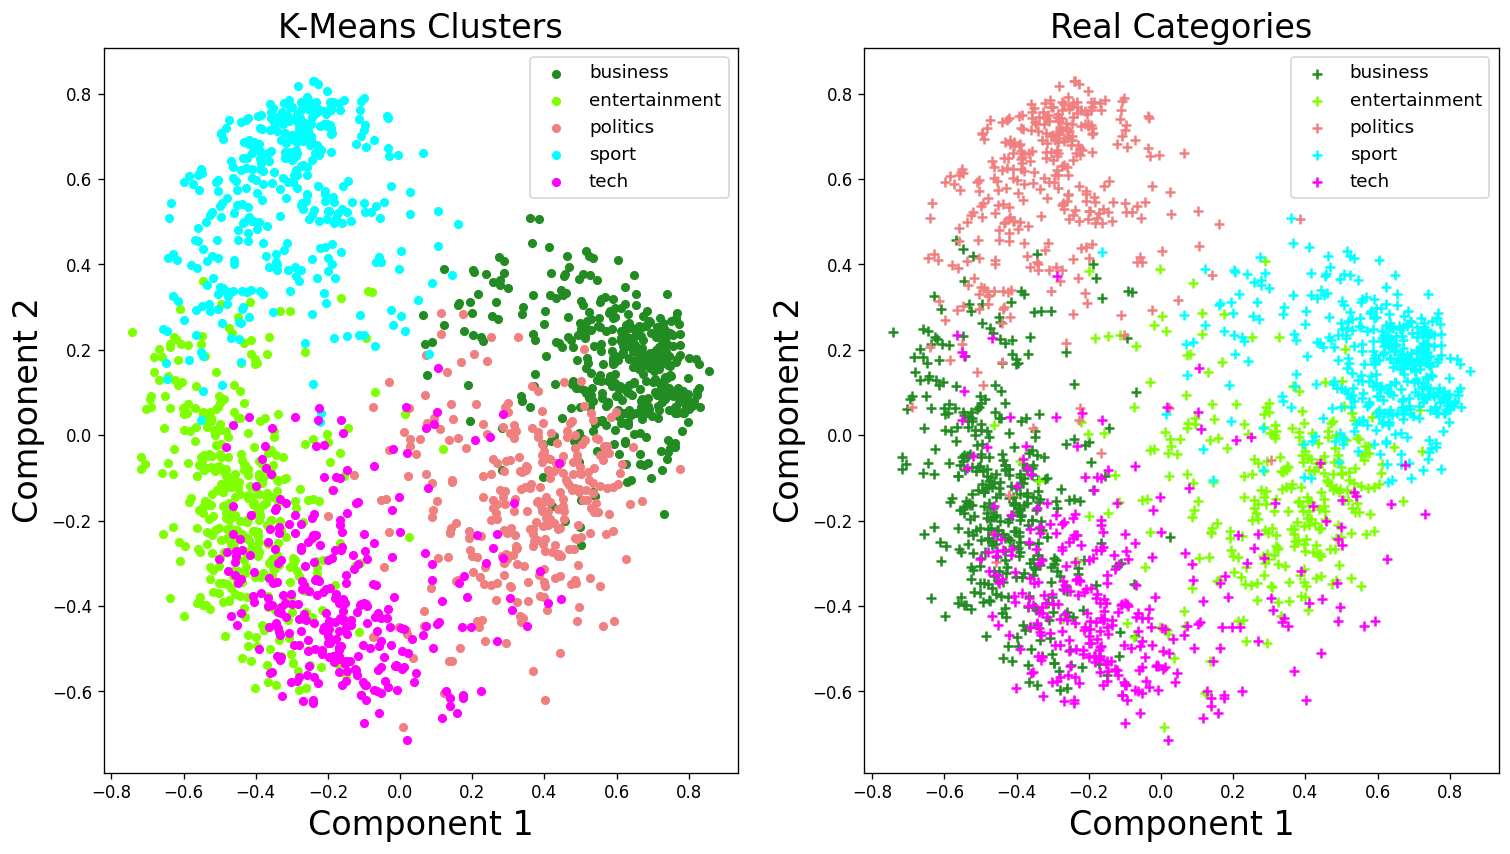

In [186]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_w2v_df['Category'] == ncl
    plt.scatter(svd_w2v_df.loc[index, 'component 1'], 
                svd_w2v_df.loc[index, 'component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Component 1', fontsize=20)
plt.ylabel('Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(svd_w2v_df.loc[index, 'component 1'], 
                svd_w2v_df.loc[index, 'component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})

### ICA

In [187]:
ica = FastICA(n_components=2)
ica_w2v = ica.fit_transform(train_w2v_norm)

#### Create a dataframe that contains the two independent components

In [188]:
ica_w2v_df = pd.DataFrame(data=ica_w2v, columns=['independent component 1', 'independent component 2'])

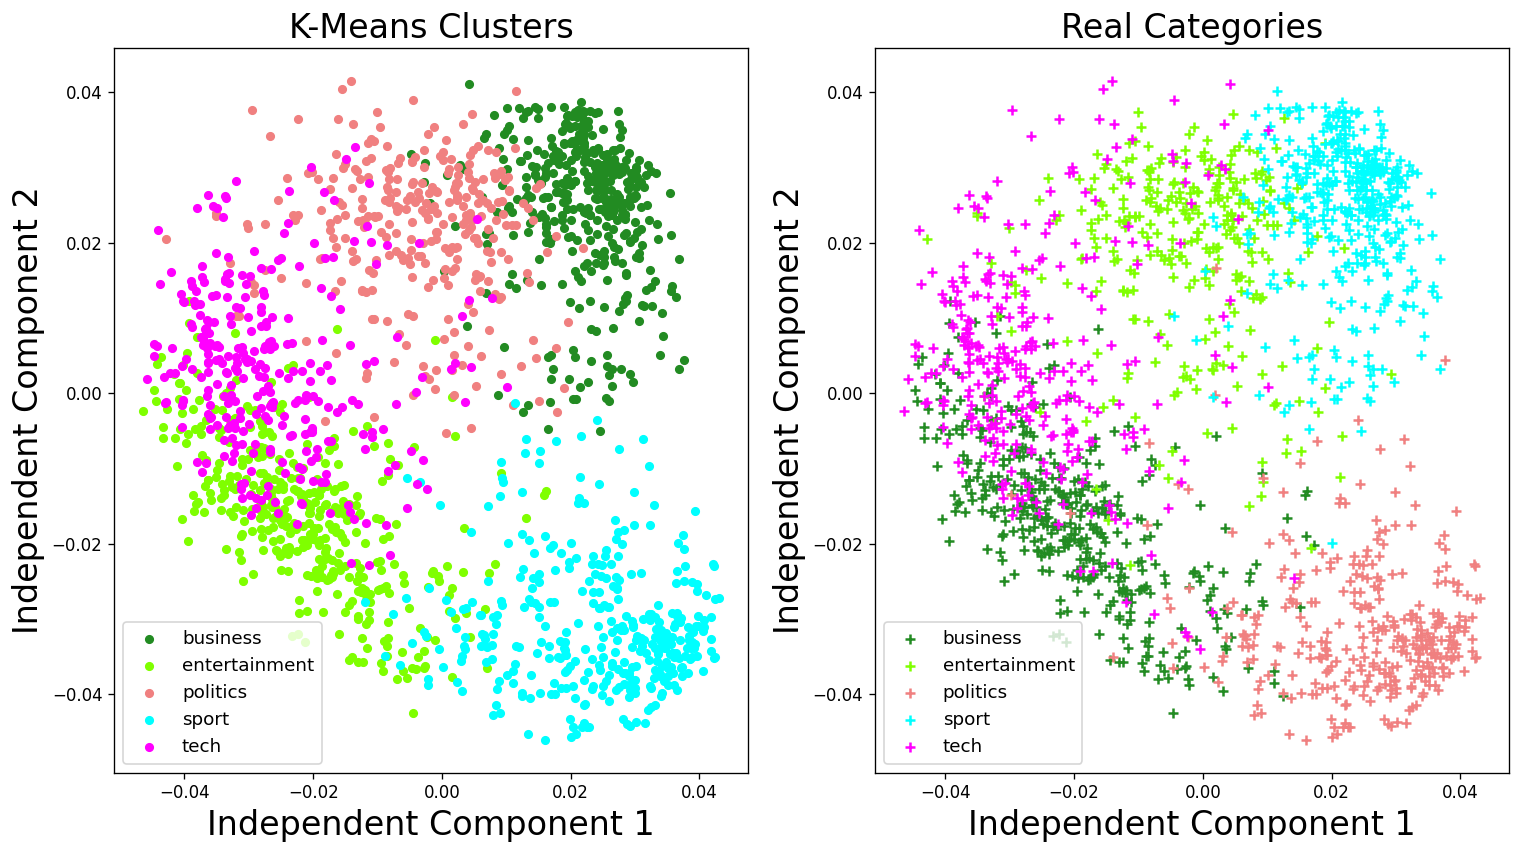

In [189]:
plt.figure(figsize=(15,8), dpi=120) 

classes = ['business', 'entertainment', 'politics', 'sport', 'tech']
colors = ['forestgreen', 'chartreuse', 'lightcoral', 'aqua', 'fuchsia']   
num_classes = [0, 1, 2, 3, 4]

plt.subplot(1,2,1)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("K-Means Clusters", fontsize=20)

for ncl, color in zip(num_classes,colors):
    index = km_w2v_df['Category'] == ncl
    plt.scatter(ica_w2v_df.loc[index, 'independent component 1'], 
                ica_w2v_df.loc[index, 'independent component 2'], c = color, s = 20)

plt.legend(classes, prop={'size': 11})

plt.subplot(1,2,2)
plt.xlabel('Independent Component 1', fontsize=20)
plt.ylabel('Independent Component 2', fontsize=20)
plt.title("Real Categories", fontsize=20)

for cl, color in zip(classes,colors):
    index = train["Category"] == cl
    plt.scatter(ica_w2v_df.loc[index, 'independent component 1'], 
                ica_w2v_df.loc[index, 'independent component 2'], c = color, marker = "+", s = 30)

plt.legend(classes, prop={'size': 11})